# Add Extra Variables to Model Output

Now we have been through running the HRLDAS/NoahMP model with single-point and 2D regional simulations. 

In this note, we will modify the code to allow extra output variables, given the advantages in the new refactor code. For example, we will output one extra variable `BTRAN`, which is related to soil moisture and ET calculation. This `BTRAN` variable have been a local variable and not a standard output. 

## Example 1. `BTRAN` variable in code v4.5 and v5.0

The `BTRAN` variable, defined as the `soil water transpiration factor (0-1)`, has been a local variable in the `NOAHMP_SFLX` subroutine in `module_sf_noahmplsm.F` code. It is an important diagnostic variable for accessing soil moisture and vegetation. 

Let's say we want to output this local variable

`  REAL                  :: BTRAN  !soil water transpiration factor (0 - 1)` 

In the v4.5 code:

1. First, we would need to go into `module_sf_noahmplsm.F`, modify the above line to add `INTENT(OUT)`

**For other local variables not defined in the main subroutine of v4.5 (NOAHMP_SFLX in module_sf_noahmplsm.F), users need to modify every level of subroutine interfaces where the targeted variable appears.
In version v5.0, this is not needed anymore, which simplifies the code modification process. （See example 2 below in this note）**

2. Then, create allocatable array in the noahmp driver, `module_sf_noahmpdrv.F`, 

3. Finally, in `IO_code/module_NoahMP_hrldas_driver.F`, add output into `add_to_output subroutine`.


In the v5.0 code:

This variable is renamed as `SoilTranspFacAcc` (the renaming itself has more physical meaning than it was `BTRAN`).
And this variable is defined in `/noahmp/src/WaterVarType.F90`:

`!=== define "state" sub-type of water (water%state%variable)
  type :: state_type`
  
......
  
`    real(kind=kind_noahmp) :: SoilTranspFacAcc           ! accumulated soil water transpiration factor (0 to 1)`

So we can follow the similar procedure as in v4.5 and output this variable in v5.0.

**Note**: A glossary for old variable names in v4.5 and new names in v5.0 is provided in the **noahmp** repo: https://github.com/NCAR/noahmp/blob/master/docs/NoahMP_refactored_variable_name_glossary_Feb2023.xlsx

 For example, for water variables: 
 
 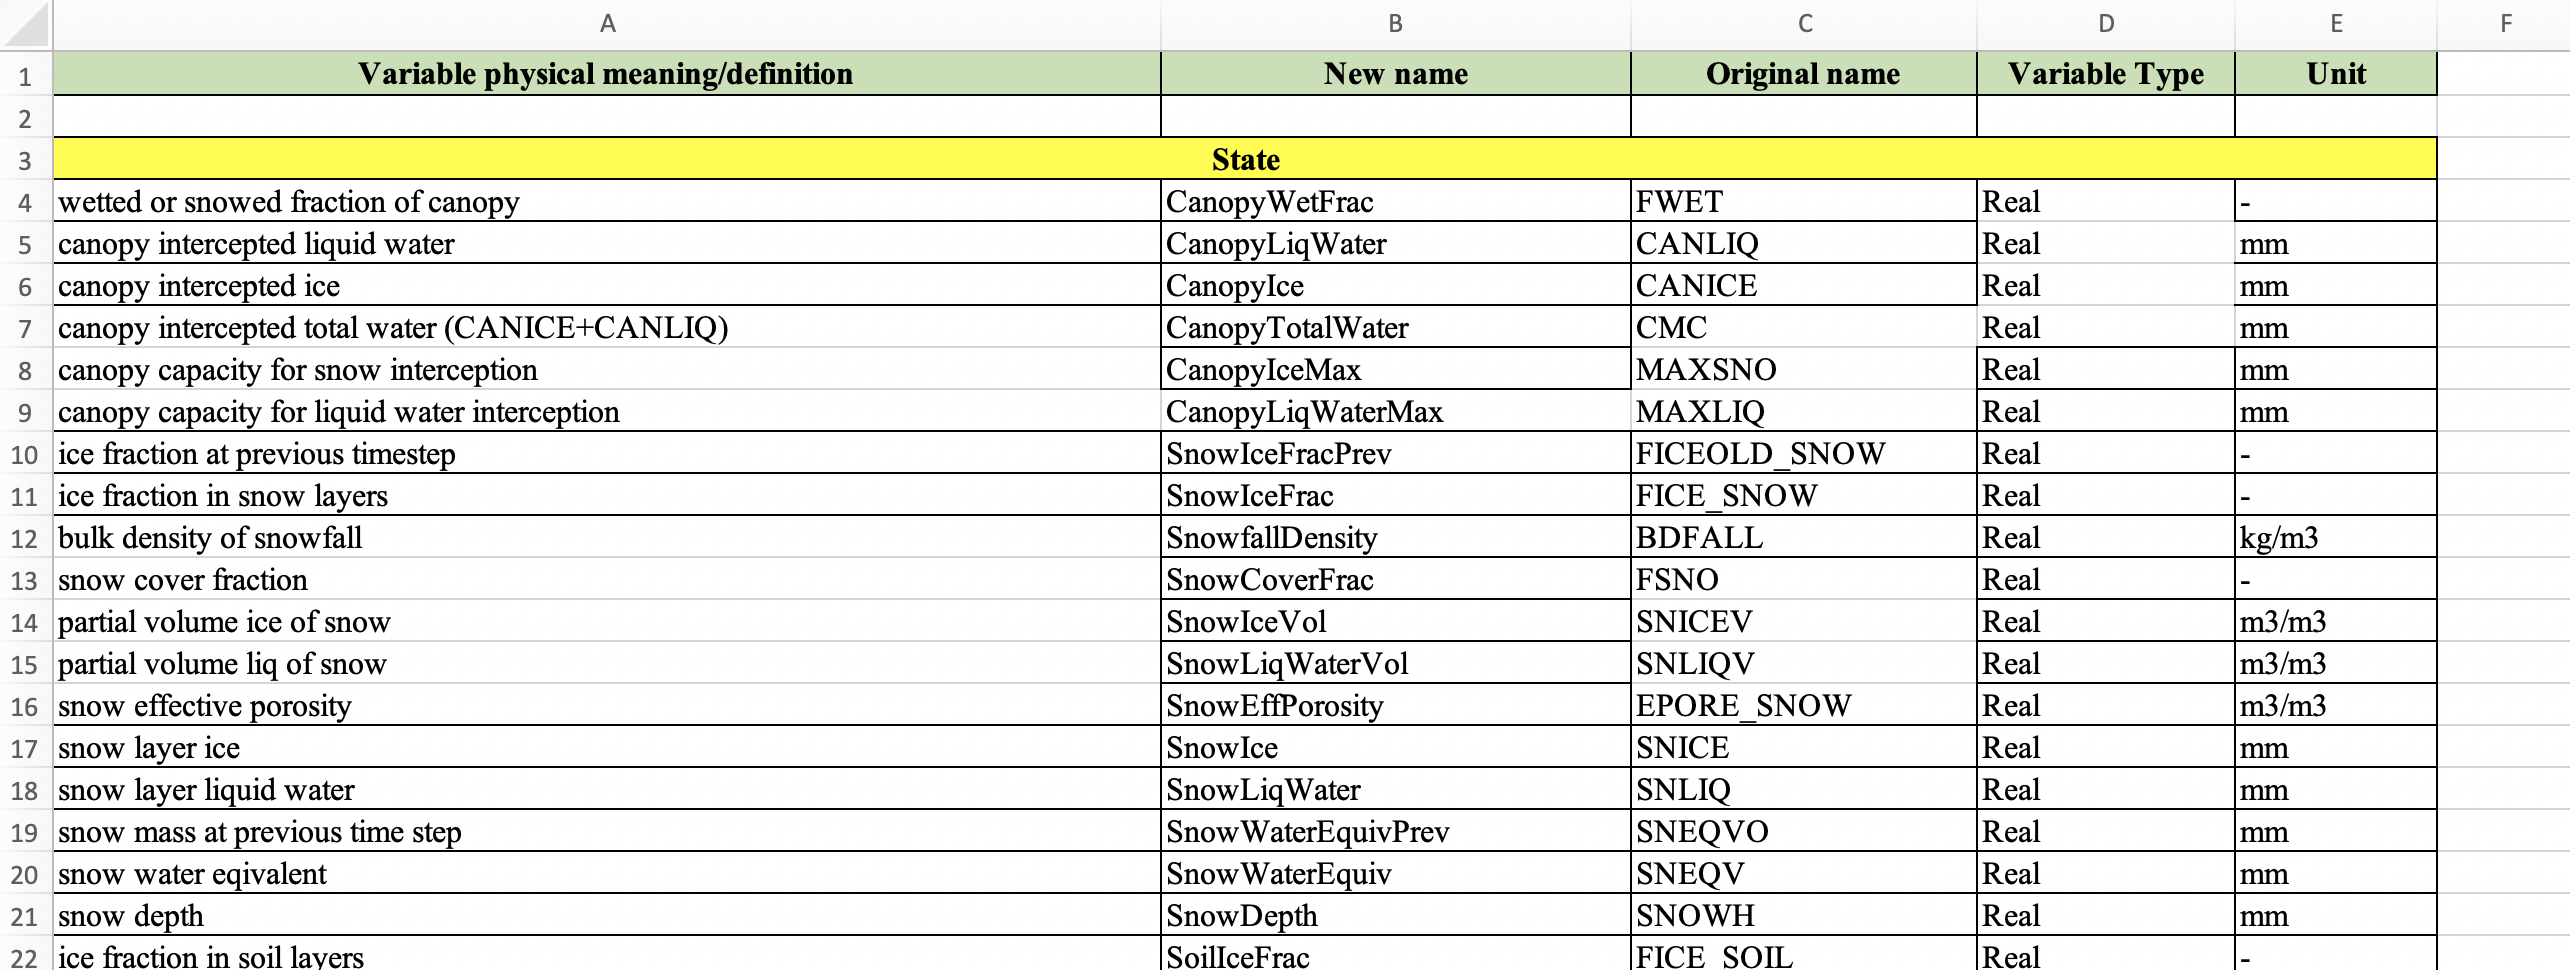
 
 ......
 
 
-----------

## 2. Define `BTRANXY` in `/noahmp/drivers/hrldas/`

### 2.1 in `NoahmpIOVarType.F90`, define `BTRANXY` as an allocatable variable for output
**L221**: `    real(kind=kind_noahmp), allocatable, dimension(:,:)    ::  BTRANXY             ! soil transpiration factor (0-1) `

### 2.2 in `NoahmpIOVarInitMod.F90`, allocate and define an initial value for `BTRANXY`
**L183**: `    if ( .not. allocated (NoahmpIO%BTRANXY)   ) allocate ( NoahmpIO%BTRANXY    (XSTART:XEND,               YSTART:YEND) ) ! soil transpiration factor (0-1) `

......

**L601**: `    NoahmpIO%BTRANXY         = 0.0`



### 2.3 Transfer in and out: from `BTRANXY` to `SoilTranspFacAcc`

**Transfer In**: `/drivers/hrldas/WaterVarInTransferMod.F90`

**L77**: `    noahmp%water%state%SoilTranspFacAcc                   = NoahmpIO%BTRANXY    (I,J)`

**Transfer Out**: `/drivers/hrldas/WaterVarOutTransferMod.F90`

**L128**: `    NoahmpIO%BTRANXY     (I,J) = noahmp%water%state%SoilTranspFacAcc`

## 3. Add `BTRANXY` to output list
In `./hrldas/IO_code/module_NoahMP_hrldas_driver.F`, `add_to_output` subroutine:

**L1120**: `               call add_to_output(NoahmpIO%BTRANXY    , "BTRANXY" , "Soil Transpiration Factor (0-1)"      , "-"                     )`

## 4. Check these modifications 
You can check above modificaitons through `git diff` command.

For example in the `./noahmp/` directory:
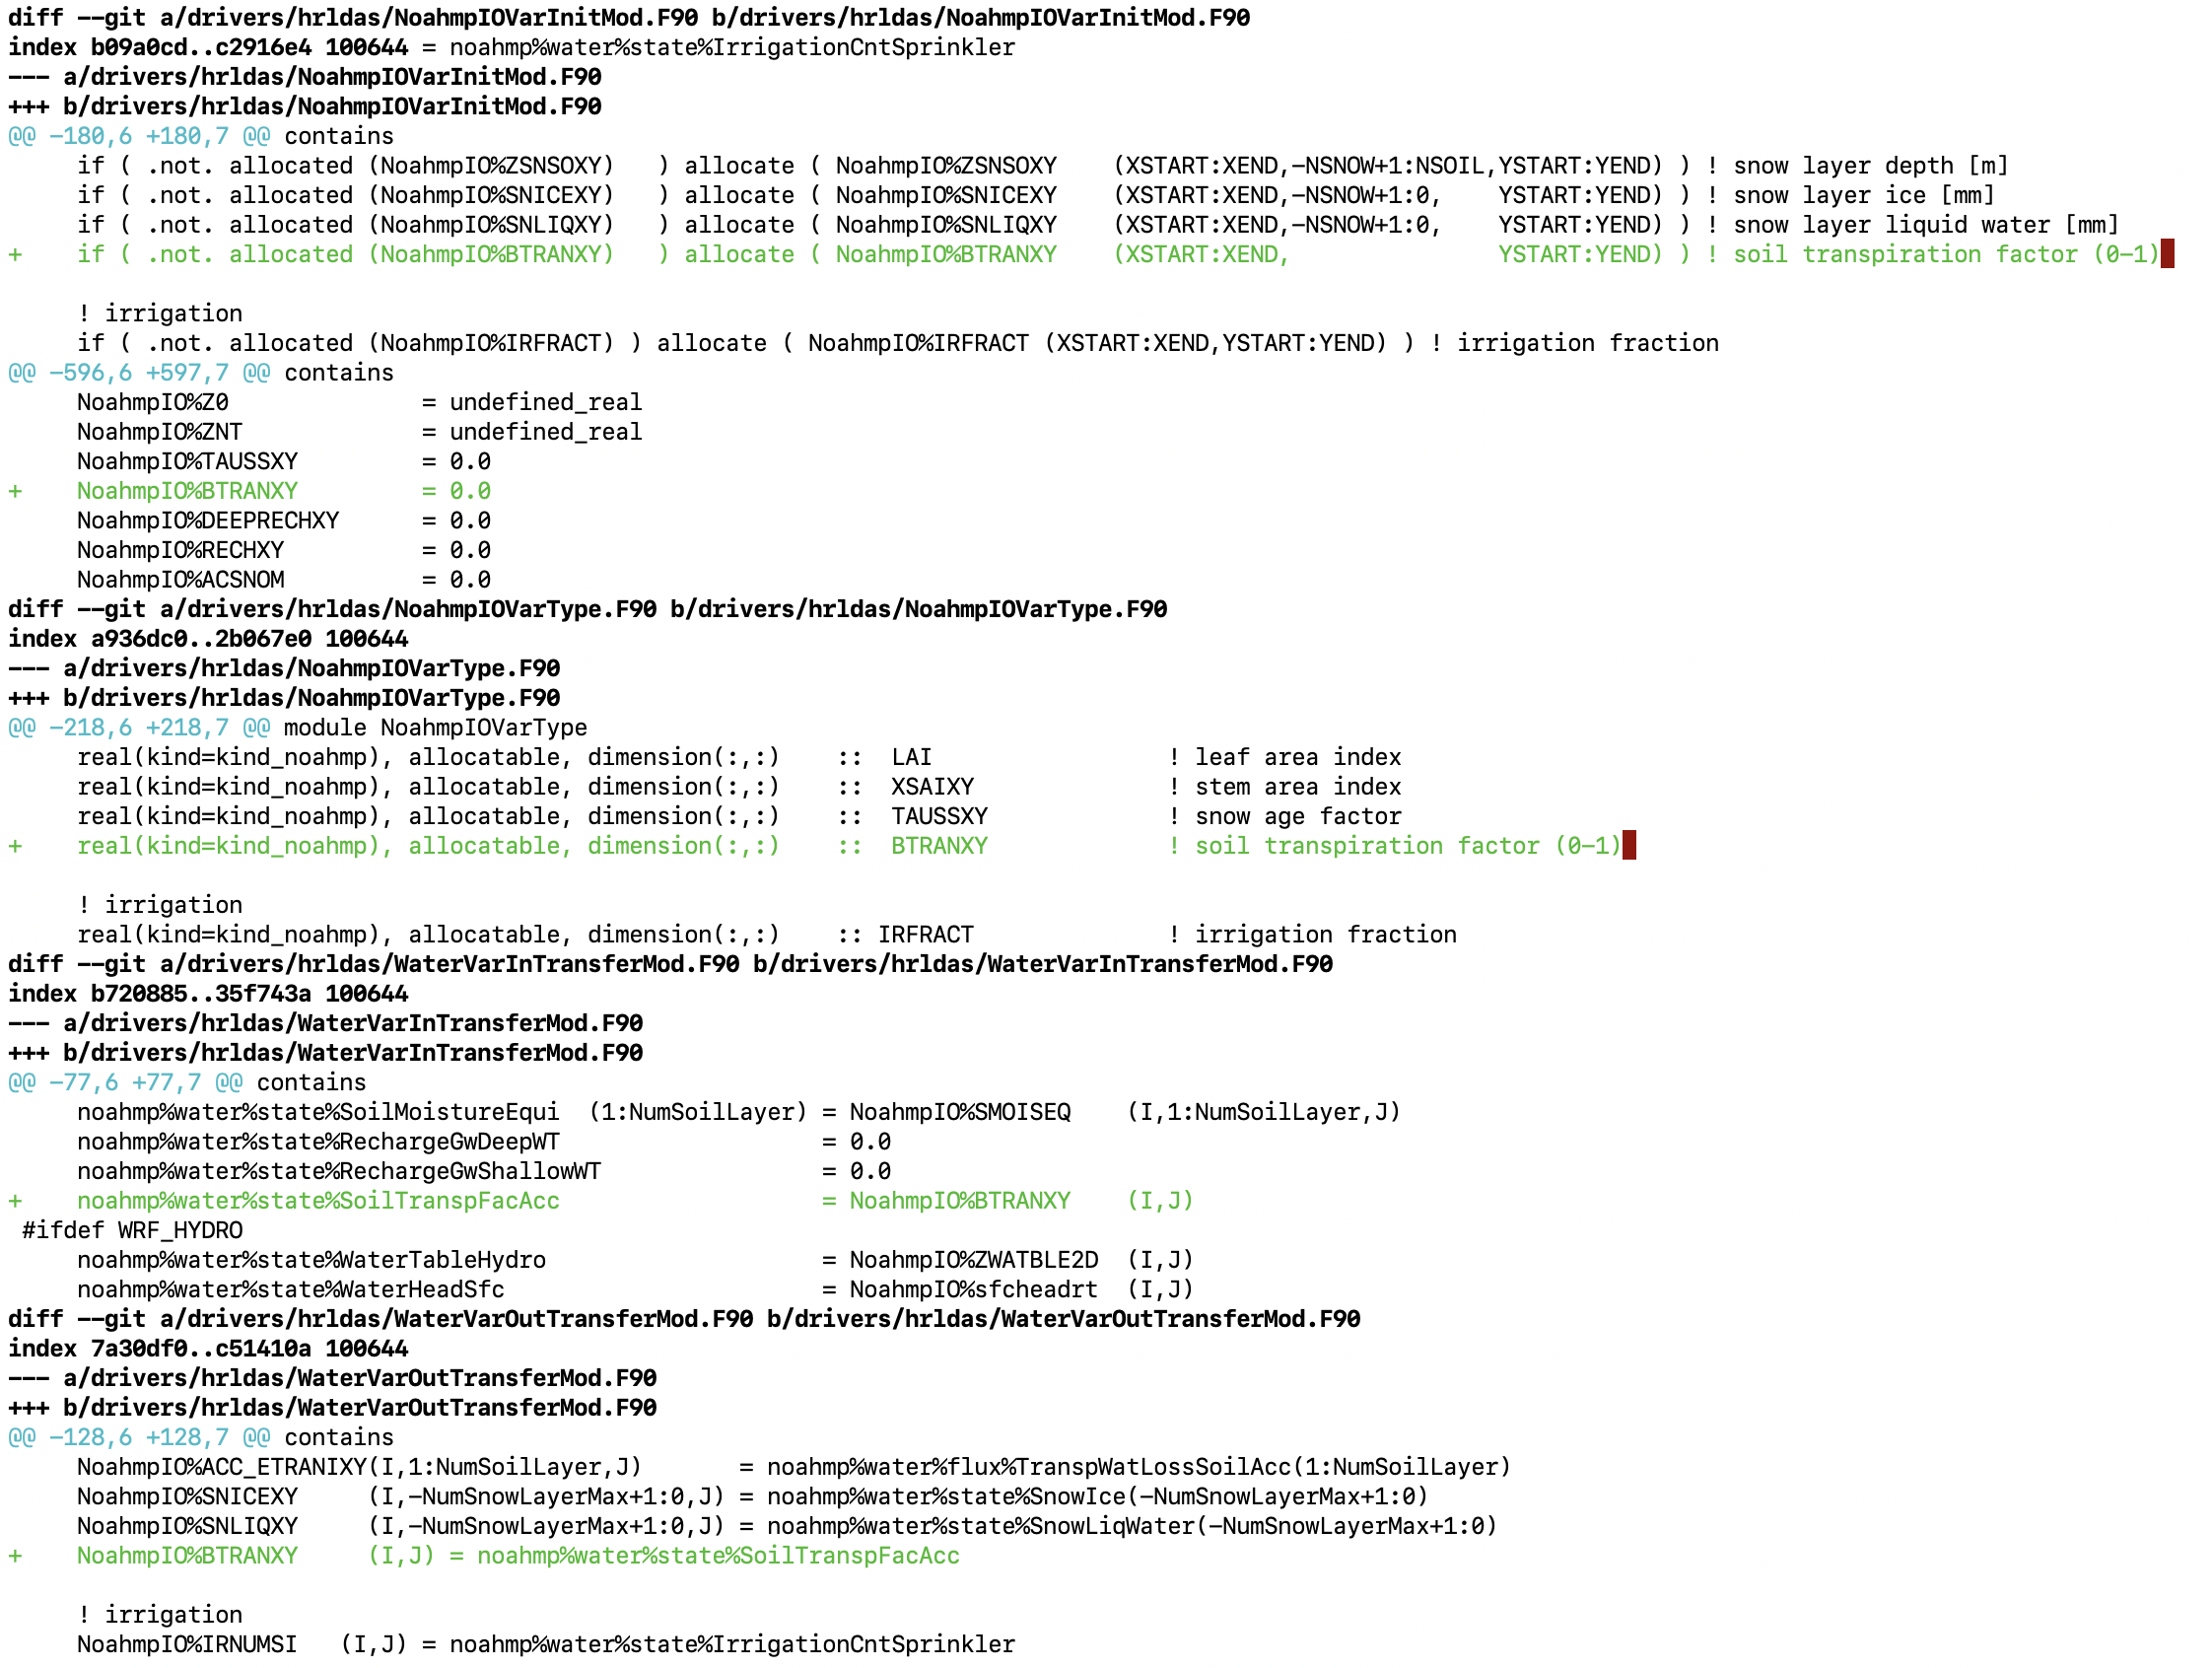

......

and in the `./hrldas/` directory:
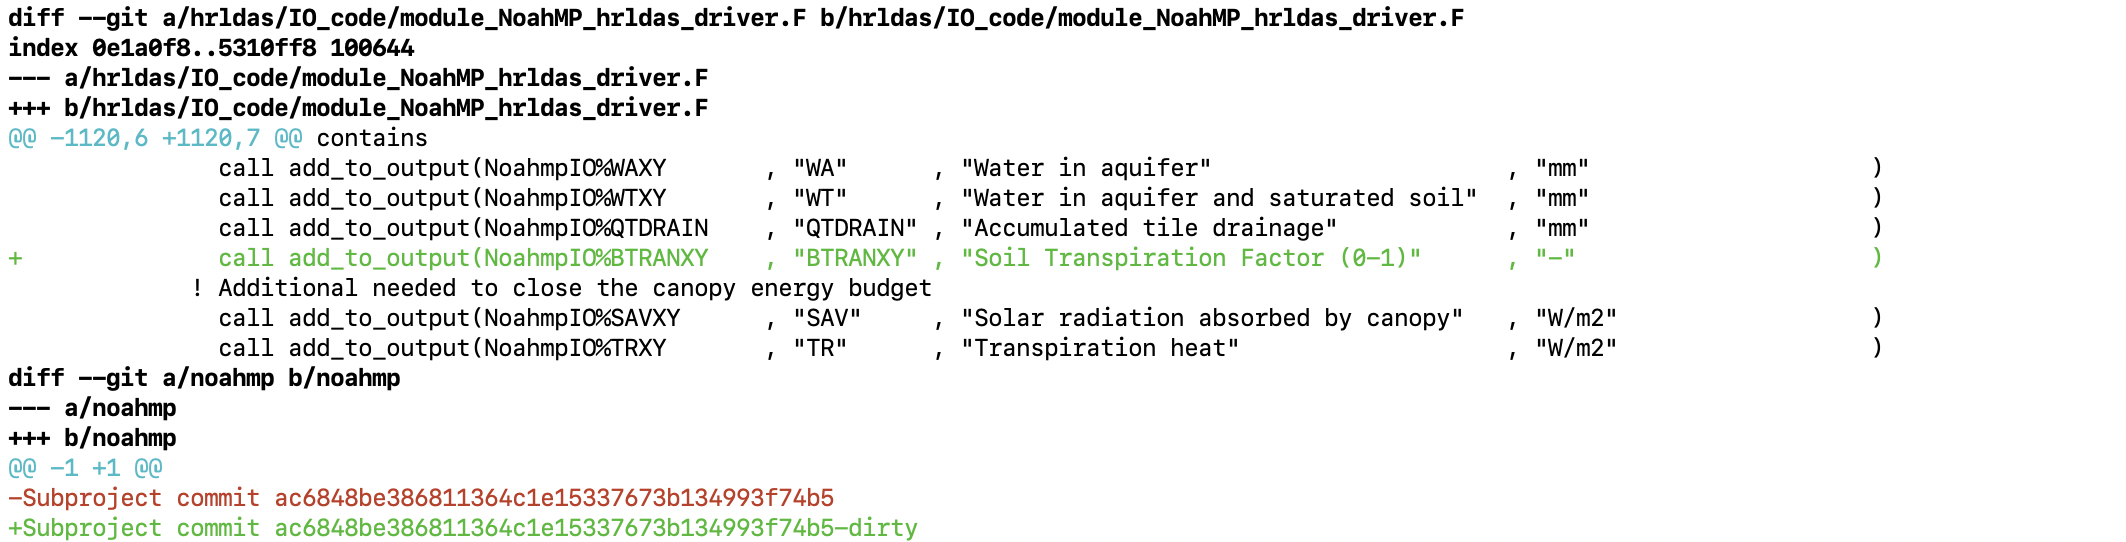

## 5. Recompile the code and check `BTRANXY` output
Again, `make` to build the modified version.

We will use the **single-point** case and exam the output `BTRAN` variable.

`cd run`

`./hrldas.exe`

`ncview 199801020030.LDASOUT_DOMAIN1 `

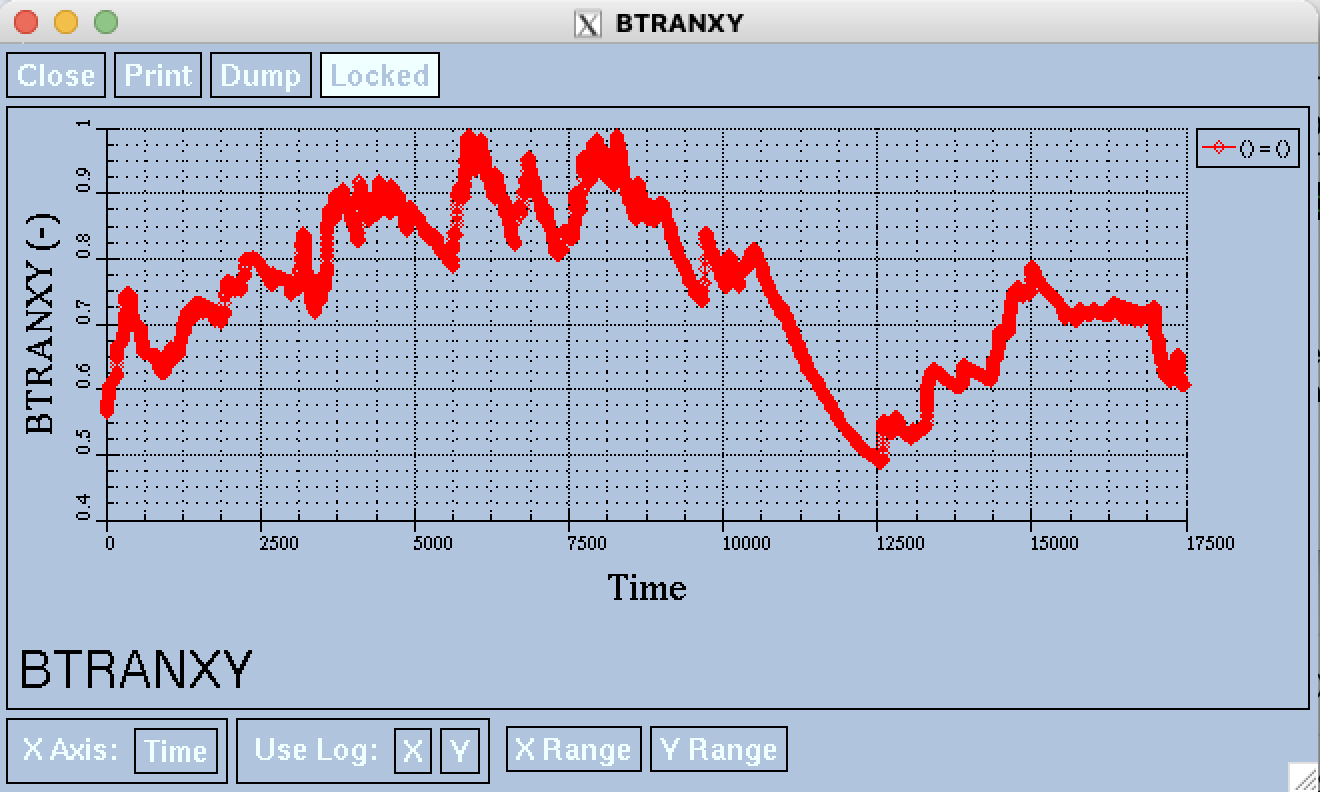

**Now you can find the `BTRANXY` variable has been successfully output!**

## Example 2. for local variables 
**For other local variables not defined in the main subroutine of v4.5 (NOAHMP_SFLX in module_sf_noahmplsm.F), users need to modify every level of subroutine interfaces where the targeted variable appears.

### Conventional way to define variable and call subroutine:
We will need to define variable in each subroutine and add its variable name whenever it is called. For example: 

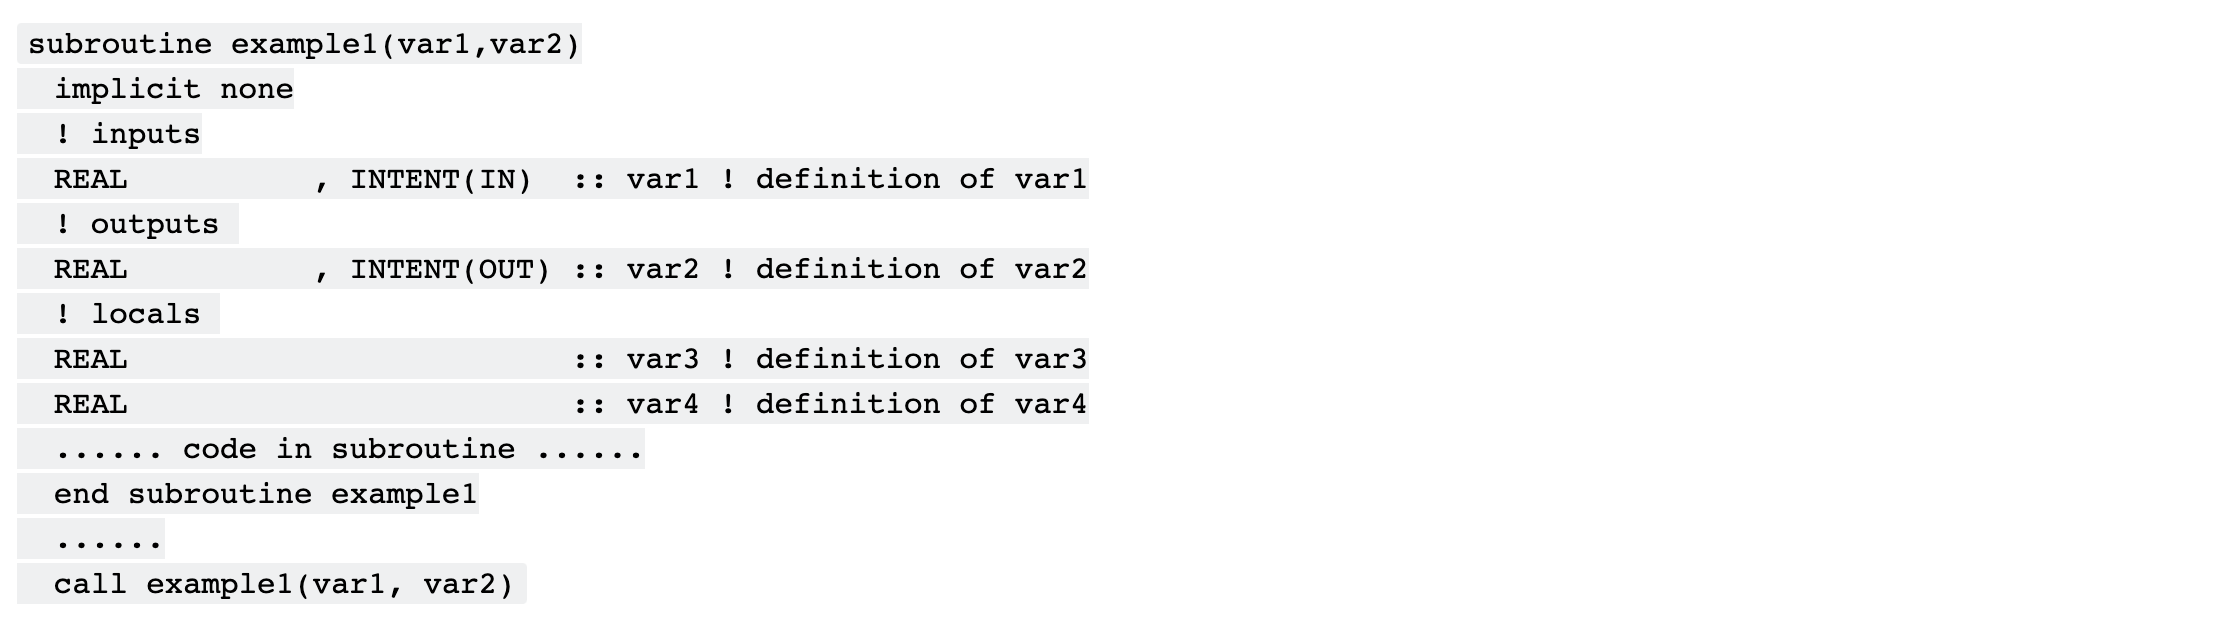

---------------------------

### Changes you would need to output local variables
  
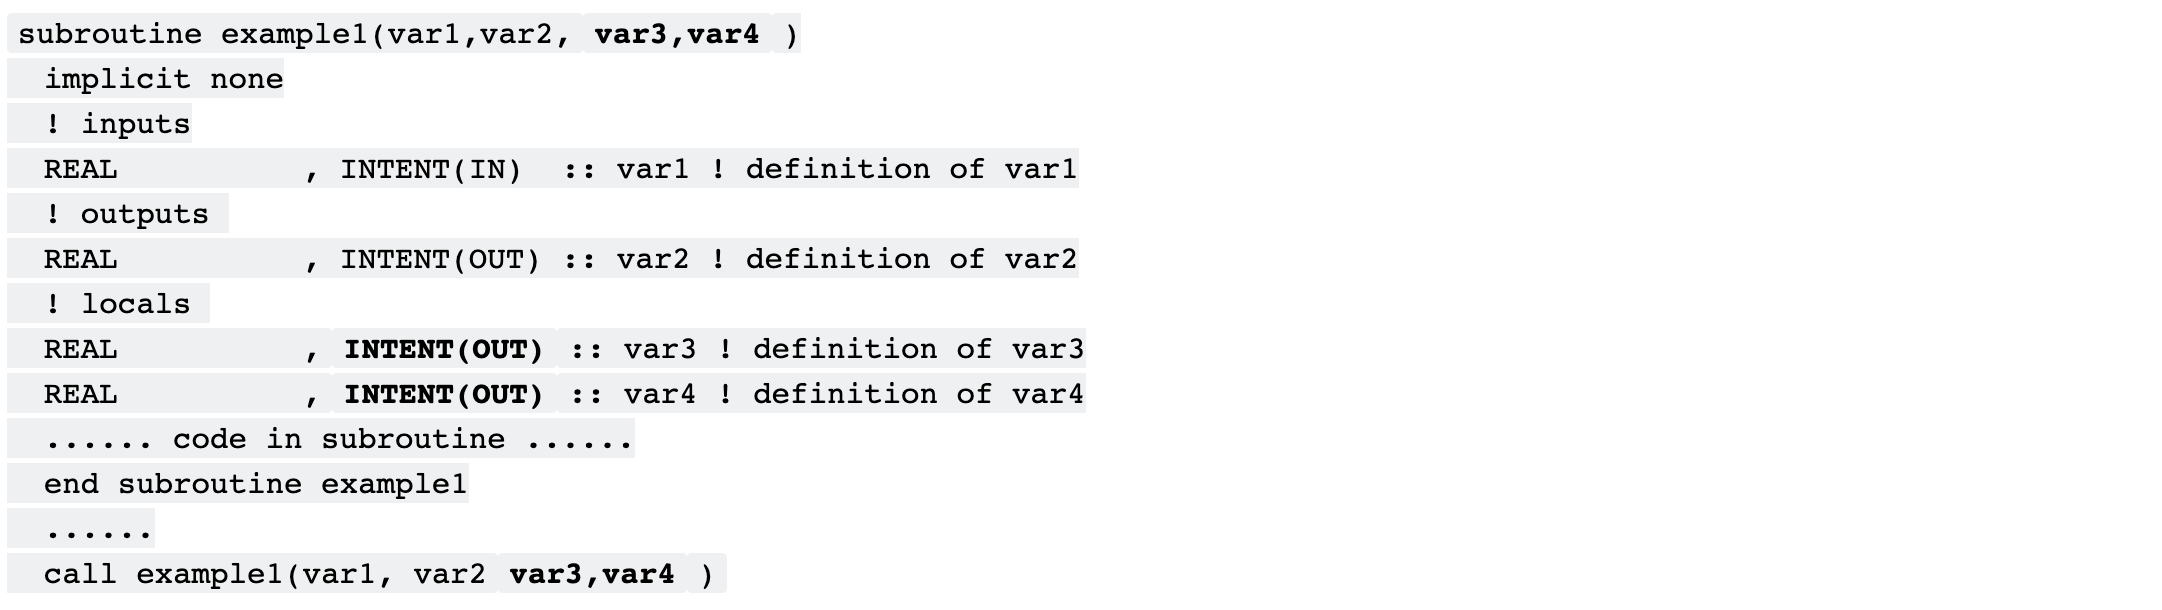  
  
  ### So, you have to define variables, add them to each level they are called.  (Which is complicated and easy to forget)
  
----------------------------



### In the refactor code v5.0:
**(1) First, we will have define variables, collectively, in a `VarType.F90` file**

**(2) Then, in each subroutine this variable appears, associate this variable**

**(3) Call this subroutine, using only `noahmp` datatype**


**In `VarType.F90`, define variables:**
 
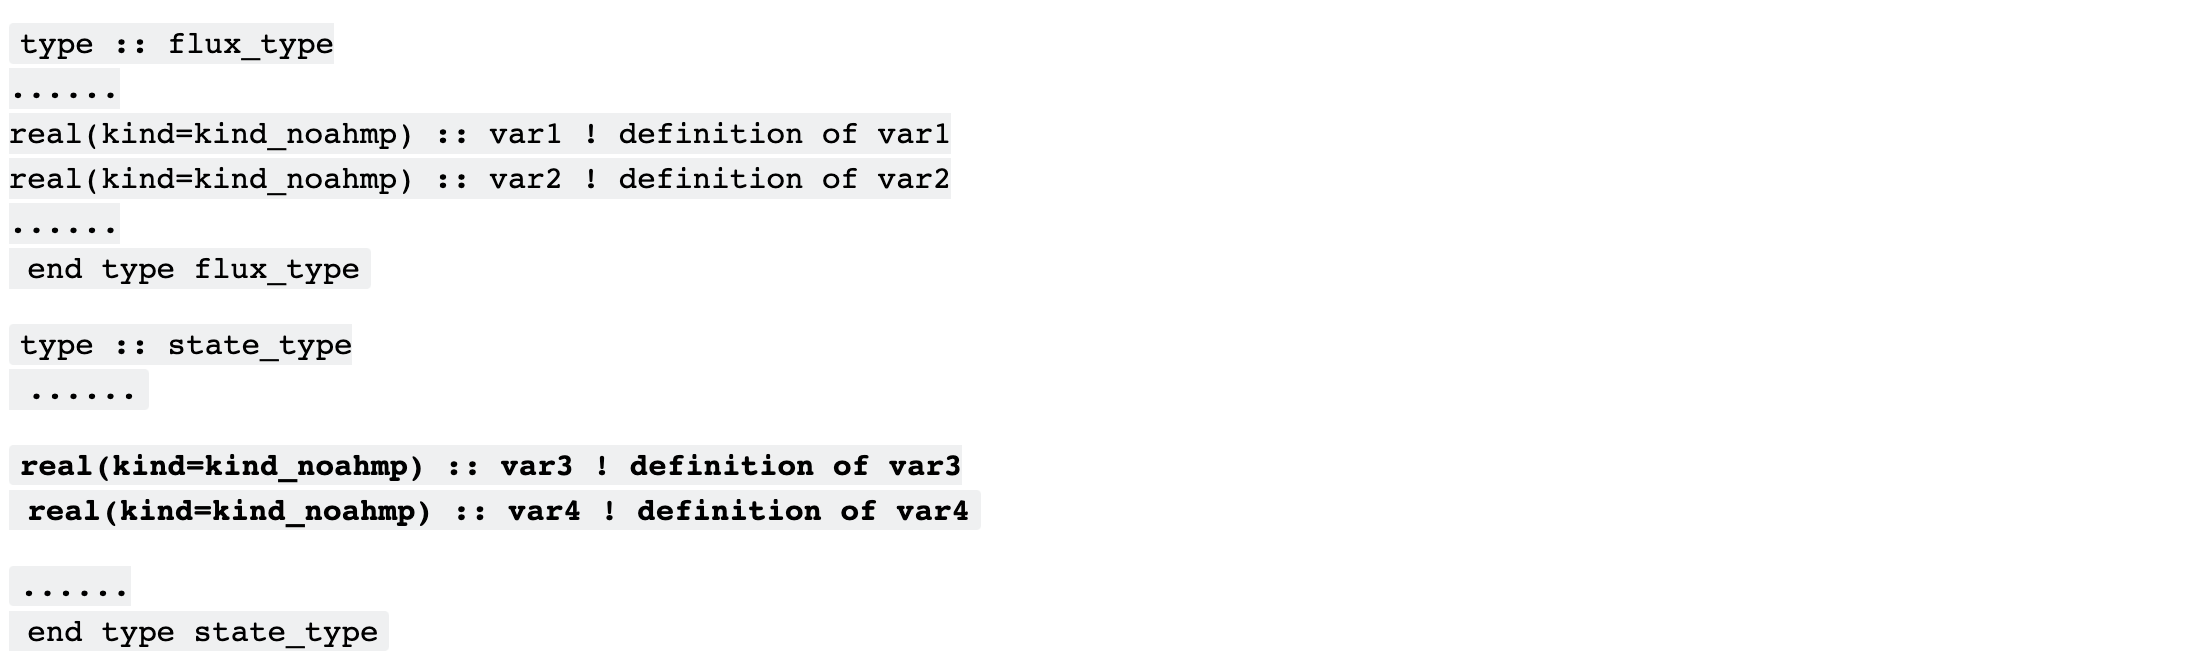

**In `example1Mod.F90`, where subroutine `example1` is defined:**

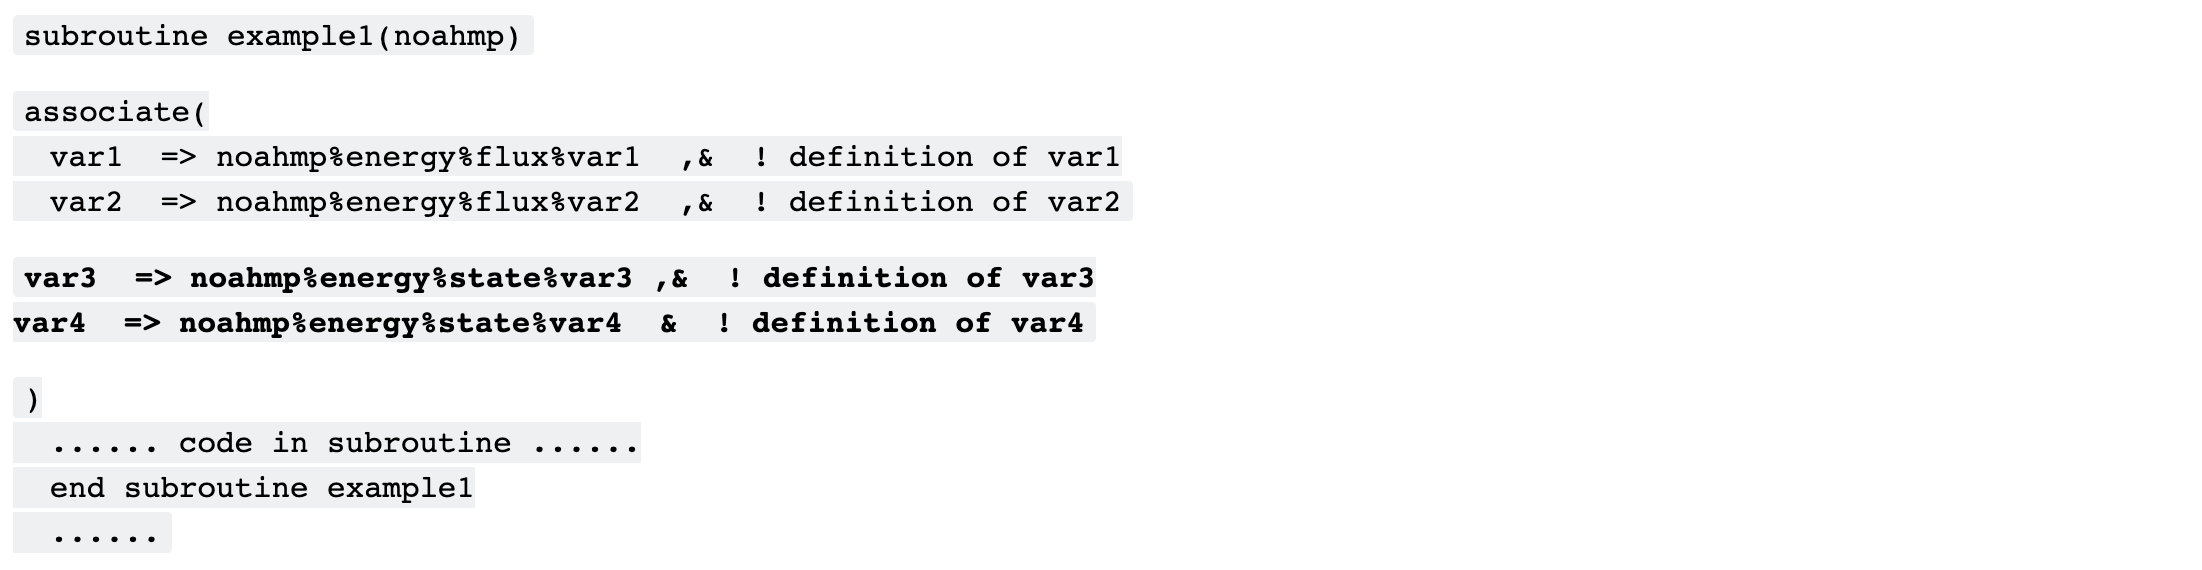

**In `MainMod.F90`, where subroutine `example1` is called:**

`call example1(`**`noahmp`**`)`

-----------------------

### In the refactor code, the user can largely take advantage of the `noahmp` data type and effectively simplify the way we define and call variables and subroutines. 

**In this example, we will look at one variable, that is defined locally within one subroutine:**

In `PhenologyMainMod.F90`:

`! local variables
    real(kind=kind_noahmp)           :: ThicknessCanBury        ! thickness of canopy buried by snow [m]`
    
    
**1. Define variable in EnergyVarType.F90** 

This variable is locally defined within this module, so that the **first thing** to do is to define it in the `VarType.F90`. For this variable is about the canopy thickness, therefore it is related to the `EnergyVarType.F90`. 

Let's define it by the end of `type :: state_type`:

`real(kind=kind_noahmp) :: RadSwBalanceError           ! error in shortwave radiation balance [W/m2]`

`real(kind=kind_noahmp) :: ThicknessCanBury            ! thickness of canopy buried by snow [m]`

**2. Associate variable in its module**

After defining the `state_type` variable `ThicknessCanBury`, we can directly associate it in `PhenologyMainMod.F90`, where it was locally defined (we can now delete this line in `local variables`).

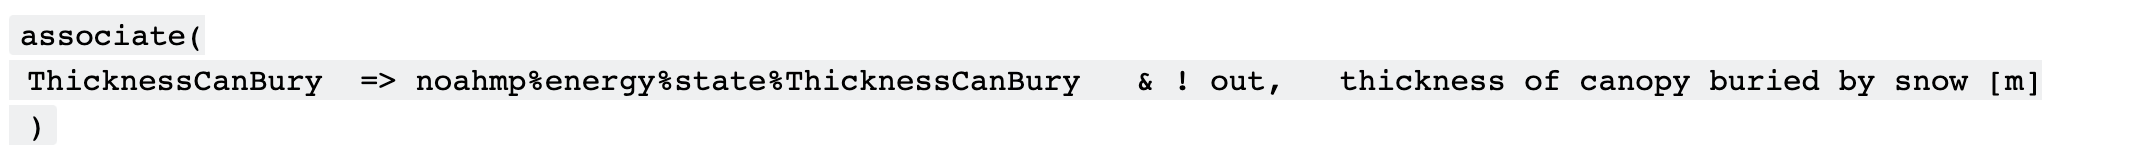

### After these two modifications, this variable is defined in `EnergyVarType.F90` and associated each time it is used in each subroutine, as a `noahmp` data type. 

### Follow the same way as in Example 1, we can output this local variable `ThicknessCanBury`

#### in `NoahmpIOVarType.F90`, define `DBXY` as an allocatable variable for output
**L222:** `    real(kind=kind_noahmp), allocatable, dimension(:,:)    ::  DBXY             ! thickness of canopy buried by snow (m) `

----------

#### in `NoahmpIOVarInitMod.F90`, allocate and define an initial value for `DBXY`
**L184:** `    if ( .not. allocated (NoahmpIO%DBXY)   ) allocate ( NoahmpIO%DBXY    (XSTART:XEND,               YSTART:YEND) ) ! soil transpiration factor (0-1) `

......

**L602:** `    NoahmpIO%DBXY            = undefined_real`

----------

#### Transfer in and out: from `DBXY` to `ThicknessCanBury`

**Transfer In**: `/drivers/hrldas/EnergyVarInTransferMod.F90`

**L58:** `    noahmp%energy%state%ThicknessCanBury = NoahmpIO%DBXY (I,J)`

**Transfer Out**: `/drivers/hrldas/EnergyVarOutTransferMod.F90`

**L115:** ` NoahmpIO%DBXY(I,J) = noahmp%energy%state%ThicknessCanBury`

----------

#### Add `DBXY` to output file
In `./hrldas/IO_code/module_NoahMP_hrldas_driver.F`, `add_to_output` subroutine:

**L1124:** `               call add_to_output(NoahmpIO%DBXY    , "DB" , "Thickness of Canopy buried by snow"      , "m"                     )`

###  Recompile the code and check `DB` output
Again, `make` to build the modified version.

We will use the **single-point** case and exam the output `DB` variable.

`cd run`

`./hrldas.exe`

`ncview 199801020030.LDASOUT_DOMAIN1 `

#### This time, we put two variables together, `DB` (canopy thickness buried by snow) and `SNOWH` (snow height):

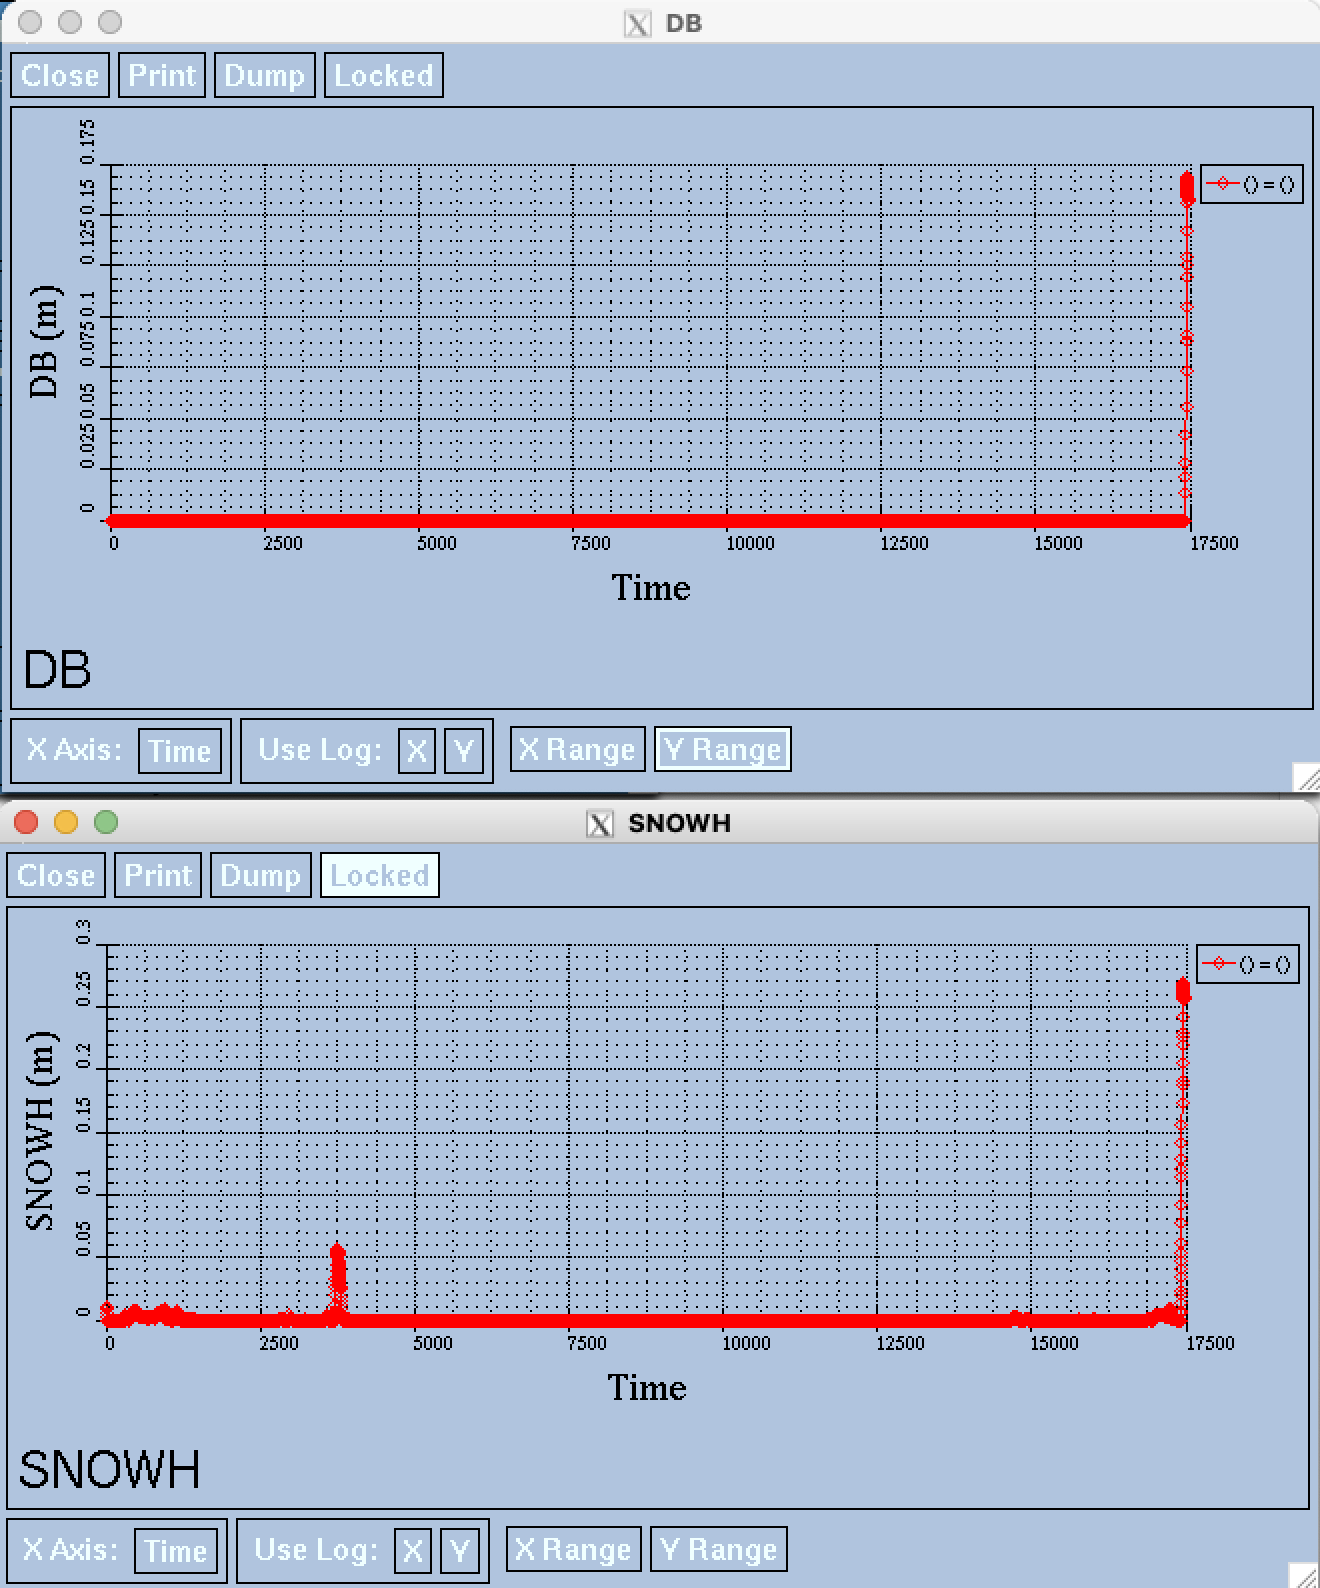

**Now you can find the `DB` variable has been successfully output! For most of the time, canopy is not buried by snow, except by the end of the year**